In [54]:
from typing import Union, Optional
from pathlib import Path
import json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from loguru import logger
import pandas as pd

HEATMAP_EXPERT_POINTS_PATH = Path("devel/.npy")





In [19]:

fn = sorted(list(Path(".").glob("*list_of_all_stitches*.xlsx")))[-1]
print(fn)
dfall = pd.read_excel(fn)

if "done_by_expert" not in dfall.columns:
    dfall["done_by_expert"] = dfall["filename"].str.contains("Ekn").astype(float)
    dfall["done_by_expert"] = dfall["done_by_expert"].astype(bool)
# dfall.done_by_expert.value_counts()


list_of_all_stitches_sorted_by_duration.2025-01-13_20-05-36.xlsx


False    442
True      28
Name: done_by_expert, dtype: int64

In [45]:
fn = dfall[dfall["done_by_expert"]==True].filename.values[5]
patch = Path(fn).stem
patch

'Ekn_Ana_8'

In [39]:

MEDIA_ROOT = Path("../piglegsurgeryweb/media/")

def get_outputdir(patch:str):
    img_pths = list((MEDIA_ROOT / "upload/").glob(f"*/*{patch}*"))
    mediafile_path = img_pths[-1]
    mediafile_path = mediafile_path.absolute().resolve()

    outputdir = list(list((MEDIA_ROOT ).glob(f"*/*{patch}*.zip"))[-1].parent.glob("*/meta.json"))[-1].parent

    outputdir = outputdir.absolute().resolve()
    return outputdir, mediafile_path



In [50]:

outputdir, mediafile_path = get_outputdir(patch)
outputdir
mediafile_path



PosixPath('/webapps/piglegsurgery/piglegsurgeryweb/media/upload/20240820-092634_Ekn_Ana_8_539656a54ac190c20b29639678b8c64bc255d01a/Ekn_Ana_8.preview.jpg')

In [55]:
def compare_distributions_by_l2_distance(pts, points, bw_adjust1=1.0, bw_adjust2=1.0):
    # Compute both KDEs.
    kde_ground = gaussian_kde(pts.T)
    kde_other = gaussian_kde(points.T)

    kde_ground.set_bandwidth(bw_method=kde_ground.factor * bw_adjust1)
    kde_other.set_bandwidth(bw_method=kde_other.factor * bw_adjust2)

    # Define a common grid that covers the support of both datasets.
    x_min = min(pts[:, 0].min(), points[:, 0].min())
    x_max = max(pts[:, 0].max(), points[:, 0].max())
    y_min = min(pts[:, 1].min(), points[:, 1].min())
    y_max = max(pts[:, 1].max(), points[:, 1].max())

    grid_size = 20
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])

    # Evaluate both KDEs on the grid.
    density_ground = kde_ground(grid_coords).reshape(X.shape)
    density_other  = kde_other(grid_coords).reshape(X.shape)

    # Calculate a similarity measure (for example, L2 distance).
    l2_distance = np.sqrt(np.sum((density_ground - density_other)**2))
    # print("L2 distance between KDEs:", l2_distance)
    return l2_distance


def compare_heatmaps_plot(
        outputdir: Union[str,Path], points_px:Optional[np.array]=None, pix_size_m:Optional[float]=None, filename=None,
        image:Optional[np.array]=None,
        tool_id=0,
        cmap="Greens",
        levels=3
):

    outputdir = Path(outputdir)
    if pix_size_m is None:
        with open(outputdir / "meta.json", "r") as f:
            meta = json.load(f)
        pix_size_m = meta["qr_data"]["pix_size"]

    if points_px is None:
        with open(outputdir / "tracks_points.json", "r") as f:
            tracks_points = json.load(f)
        points_px = np.asarray(tracks_points["data_pixels"][tool_id])
    else:
        points_px = np.asarray(points_px)

    logger.debug(f"{points_px.shape=}")
    logger.debug(f"{pix_size_m=}")
    if points_px.size < 8:
        return None, None
    # points_m = points_px * pix_size_m

    pts_gt = np.load(HEATMAP_EXPERT_POINTS_PATH)

    plt.figure()

    if image is None:
        fn_small = list(outputdir.glob("__cropped.*.jpg"))[0]
        image = skimage.io.imread(fn_small, as_gray=True)
    else:
        if image.ndim == 3:
            image = skimage.color.rgb2gray(image)
    plt.imshow(image, cmap='gray')
    plt.plot(points_px[:, 0], points_px[:, 1], ".", alpha=0.2, color="red", markersize=1)
    # alpha=0.5, markerfacecolor=(1,1,0,0.1)
    # )
    # save dimensions of the plot
    pts_px = (pts_gt / pix_size_m) + np.median(points_px, axis=0)
    sns.kdeplot(x=points_px[::10,0], y=points_px[::10,1],
                # cmap=None,
                cmap=cmap,
                fill=True, bw_adjust=2., levels=levels,alpha=0.5)
    sns.kdeplot(x=pts_px[::10,0], y=pts_px[::10,1], cmap=cmap, fill=False, bw_adjust=2.0, levels=levels)
    points_normed = (points_px - np.median(points_px, axis=0)) * pix_size_m

    l2_distance = compare_distributions_by_l2_distance(points_normed, pts_gt, bw_adjust1=2.0, bw_adjust2=2.0)
    sigma = np.mean(np.var(pts_gt))
    sigma = 2000.0
    score = np.exp( - l2_distance / sigma)
    score_100 = 100 * score
    plt.text(0.02 * image.shape[1], 0.98 * image.shape[0], f"{score_100:.0f}%", fontsize=12, color="red")

    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)
    # turn off axis
    plt.axis("off")
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
        plt.close()
    return l2_distance, score


In [41]:
outputdir

PosixPath('/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20240820-093944_ahq68n26lndl/SA_20240820-093944')

2025-02-12 13:43:34.288 | DEBUG    | __main__:compare_heatmaps_plot:52 - points_px.shape=(589, 2)
2025-02-12 13:43:34.289 | DEBUG    | __main__:compare_heatmaps_plot:53 - pix_size_m=0.0003860936734953825


(946.1528906252333, 0.6230824376252699)

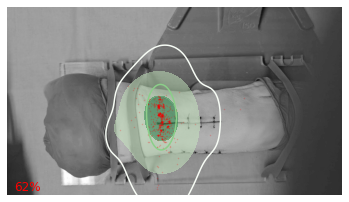

In [56]:


compare_heatmaps_plot(outputdir, points_px=None, pix_size_m=None, filename=None, image=None, tool_id=0, cmap="Greens", levels=3)

In [48]:
with open(outputdir / "meta.json", "r") as f:
    meta = json.load(f)
meta

{'filename_full': '/webapps/piglegsurgery/piglegsurgeryweb/media/upload/20240820-093944_Ekn_Ana_12_663fae963c61a619fce961ce7f857a7539fc2b52/Ekn_Ana_12.mp4',
 'fps': 30,
 'frame_count': 1447}